In [21]:
import re
import random
import pandas as pd
import hashlib

In [22]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [23]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Email Auth and Security,423.297864,52.912233,96.000360,8
VMWare,887.154829,20.631508,46.960440,43
Logging in Python,1105.121889,78.937278,224.163178,14
Azure Private DNS,1106.165730,58.219249,130.320100,19
C# Basics,1153.687323,37.215720,77.212383,31
Azure AD Authentication,1209.842461,93.064805,255.818074,13
Azure Functions + Visual Studio,1233.726254,94.902020,198.836068,13
RAG Project,1442.292262,90.143266,218.798433,16
Azure Compute Gallery,1480.198809,37.004970,100.688591,40
Debugging in VS Code,1653.294838,97.252638,369.963474,17


# Histogram

sum of ages: ~50350.85


<Axes: >

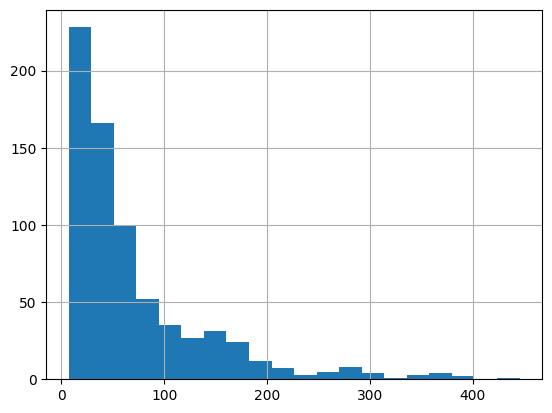

In [24]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [25]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [26]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [27]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [28]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [29]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [30]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [31]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [32]:
# n=10
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [33]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 712
Total card age: 50350.85


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
545,Azure Developer Associate,Where do Application Insights telemetry tables...,d5a8469fce507684c17e1dc224588031,-383.795707,-105.834126,383.795707,6455.881712,0.570442,0,0
548,Azure Developer Associate,Which App Service deployment method enables CI...,6dc42c6bb692381c9db51d6ac813936e,-304.244271,-105.834126,383.795707,6455.881712,0.570442,3,0
552,Azure Developer Associate,Which Azure Monitor autoscale profile type all...,c5535f58e554c2780c09946a5b119cea,-277.383956,-105.834126,383.795707,6455.881712,0.570442,6,0
554,Azure Developer Associate,How do you move Hot-tier blobs not modified fo...,984acf4d80365479d4e8abf3ffd14901,-219.626667,-105.834126,383.795707,6455.881712,0.570442,9,0
556,Azure Developer Associate,Which persistence setting minimizes storage co...,80195742cf378c711ab51bf4d8523fb0,-201.100568,-105.834126,383.795707,6455.881712,0.570442,12,0
560,Azure Developer Associate,Q: What are Redis’s primary data structures?\n...,6ce13d0f20f58b90b8f4aa2f55afee98,-168.028944,-105.834126,383.795707,6455.881712,0.570442,15,0
563,Azure Developer Associate,How do you ensure Event Grid events that fail ...,240bd178793ec4300f6b066c8ef85062,-151.132334,-105.834126,383.795707,6455.881712,0.570442,18,0
566,Azure Developer Associate,Which role is required to generate a user dele...,4cd23bedbb8767d0fa5ef3af1af19dc8,-104.506392,-105.834126,383.795707,6455.881712,0.570442,21,0
569,Azure Developer Associate,Which two services guarantee FIFO delivery and...,f714061361660e025cdfbfce4b0719f2,-74.119418,-105.834126,383.795707,6455.881712,0.570442,24,0
572,Azure Developer Associate,How do you limit an Azure Functions consumptio...,0b80e3b0fc6f6436048f8567f9fcea64,-66.911732,-105.834126,383.795707,6455.881712,0.570442,27,0


## Age Max

In [34]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [35]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [36]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [37]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
100,Azure Functions + PP365,HTTP Triggers\nA type of function trigger that...,b9e42ab2e8e591023bd1aa43b8509bfc,-445.725250,-88.815366,445.725250,1865.122692,0.790010,0,0
485,PnP PowerShell,Secure Password Handling\nPractices for managi...,274158ed857c87a86d296e65705f10da,-384.949861,-79.656140,384.949861,4779.368387,0.004878,0,0
545,Azure Developer Associate,Where do Application Insights telemetry tables...,d5a8469fce507684c17e1dc224588031,-383.795707,-105.834126,383.795707,6455.881712,0.570442,0,0
236,Python,Q:\nWhat happens if you try to call gen.next()...,a56125c87641d3bb052be7366138b43a,-376.060833,-102.450039,376.060833,3790.651437,0.013654,0,0
64,Debugging in VS Code,"1. Debugger\nA tool used to inspect, control, ...",e5f2354be4982ffd49ff5162d37e9a30,-369.963474,-97.252638,369.963474,1653.294838,0.453281,0,0
101,Azure Functions + PP365,Virtual Environment Activation\nThe process of...,f4ebac7aac964a3452e1734f5f37fcea,-365.477081,-88.815366,445.725250,1865.122692,0.790010,1,1
546,Azure Developer Associate,Why choose Azure Container Apps instead of Azu...,8c3d7ea082d3ab09d66623077af2f1b9,-361.522952,-105.834126,383.795707,6455.881712,0.570442,1,1
547,Azure Developer Associate,Where do you associate a stored access policy ...,902bb129e8b619f0bbcf5a9a924c2230,-346.488914,-105.834126,383.795707,6455.881712,0.570442,2,2
237,Python,Q:\nWhat are the two essential methods that an...,558bcbe4e40c504fe6e977eb903fb48d,-345.427874,-102.450039,376.060833,3790.651437,0.013654,1,1
486,PnP PowerShell,System.IO.Stream (System.IO)\nRepresents a seq...,3f146f4a53f3f36ced6256f3cfc16375,-342.886747,-79.656140,384.949861,4779.368387,0.004878,1,1


In [38]:
existing_cards.head(10).sum()

head                   Azure Developer AssociateAzure Developer Assoc...
body                   Where do Application Insights telemetry tables...
hash                   d5a8469fce507684c17e1dc2245880316dc42c6bb69238...
age                                                         -1950.849991
subject_mean_age                                            -1058.341264
subject_highest_age                                          3837.957072
subject_age_sum                                             64558.817125
head_random_roll                                                5.704416
count                                                                135
n_fold                                                                 0
dtype: object

In [39]:
existing_cards['age'].mean()

-70.71748289104744